# Entrega
## Destacados
A fin de comprender la opinion general de los usuarios acerca de las Hamburguesas, se propone identificar comentarios o conceptos positivos y negativos, realizando analisis de texto sobre un conjunto de tweets obtenidos a traves de la API de Twitter.
Para la busqueda de tweets, se empleo unicamente el termino "hamburguesa", obteniendo un conjunto donde cada elemento esta compuesto por el usuario, el texto, la hora y el idioma del tweet. La cantidad de tweets obtenidos en principio es de 10,000. De los mismos se seleccionan aquellos cuyo idioma sea español, quedando 9468. 

In [1]:
import pandas as pd
df=pd.read_csv(r'tweets_worldwide_hamburguesa.csv')
df=df[df.langs == 'es']
df=df.reset_index()
print(df.shape)
df.head()

(9468, 6)


,index,Unnamed: 0,screen_names,texts,dates,langs
0,0,0,excessvs,+ La vida de una italiana estaba llena de clic...,2021-04-28 00:20:33,es
1,1,1,EuSiso,tengo +3 meses sin comer hamburguesa o pasta y...,2021-04-28 00:20:28,es
2,2,2,_Sosaluis_,Que ganas de una hamburguesa,2021-04-28 00:20:14,es
3,3,3,SierraTeff,Milanesa o hamburguesa\nTEAM CAFINAPP,2021-04-28 00:20:06,es
4,5,5,DraArias,Estoy haciendo un pan brioche de hamburguesa q...,2021-04-28 00:19:48,es


#### Sentiment Prediction

Dado que no se encontro un dataset de tweets en español que tuvieran el sentiment de cada tweet clasificado, y no tenemos el tiempo de fabricar un corpus, se busca modelos.
Se encuentra y se prueba el siguiente modelo [spanish_sentiment_analysis](https://github.com/aylliote/senti-py), entrenado con 1M de reviews/comentarios de Trip Advisor, Pedidos Ya, Mercado Libre, Twitter entre otros. 
Pasa la frase por un pipeline donde la misma es vectorizada, se le extraen las features más importantes y se clasifica utilizando Multinomial Naive Bayes, un modelo utilizado regularmente en PLN.

In [2]:
from classifier import *

clf = SentimentClassifier()

/home/tizianne/.local/share/virtualenvs/ADS-8sBludAP/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict


#### Preprocessing

El string es preprocesado, aplicando reglas como pasaje a lowercase, remoción de acentos, reemplazo de palabras frecuentes de uso coloquial, acortado de términos y más. El listado completo de preoprocesamiento se encuentra en la descripción del [modelo](https://github.com/aylliote/senti-py#the-preprocessing), The Preprocessing.

#### Prediction

De la misma forma, se aplican algunas reglas a la hora de realizar la predicción, como por ejemplo dividir la frase en caso de encontrar un token como *pero*, ya que es probable que el sentimiento se encuentre más reflejado en la segunda parte, que en la primera. El resto de las [reglas](https://github.com/aylliote/senti-py#the-prediction), aparecen en el la seccón de github, The Prediction.

### Sentiment Prediction

Se aplica el modelo para predecir el sentimiento de los tweets obtenidos anteriormente.

In [3]:
df['sentiment'] = df.apply(lambda row: clf.predict(row.texts), axis=1)
df.head()

,index,Unnamed: 0,screen_names,texts,dates,langs,sentiment
0,0,0,excessvs,+ La vida de una italiana estaba llena de clic...,2021-04-28 00:20:33,es,0.074163
1,1,1,EuSiso,tengo +3 meses sin comer hamburguesa o pasta y...,2021-04-28 00:20:28,es,0.315672
2,2,2,_Sosaluis_,Que ganas de una hamburguesa,2021-04-28 00:20:14,es,0.452559
3,3,3,SierraTeff,Milanesa o hamburguesa\nTEAM CAFINAPP,2021-04-28 00:20:06,es,0.202865
4,5,5,DraArias,Estoy haciendo un pan brioche de hamburguesa q...,2021-04-28 00:19:48,es,0.971214


Inicialmente, se comienza trabajando con únicamente dos sentimientos: **positivo** y **negativo**, se prueban varios valores de umbral como por ejemplo:
- \>0.4 Positivo // <=0.4 Negativo
- \>0.5 Positivo // <=0.5 Negativo
- \>0.6 Positivo // <=0.6 Negativo 

Y se realiza el proceso de mineria de texto para cada uno, lo cual arroja conclusiones interesantes al comparar las partes. Por ejemplo, a medida que se incrementa el umbral para los tweets positivos, el largo de los mismos tiende a descender. La gente se esmera más al realizar comentarios negativos!

Igualmente, habiendo avanzado bastante en el proceso, se hace notorio que la inclusión de un tercer sentimiento **neutral** es imprescindible, ya que hay comentarios que semánticamente no tiene sentido clasificar como positivo o negativo. Por ejemplo:

In [4]:
df.iloc[2, [2,3]]

screen_names                      _Sosaluis_
texts           Que ganas de una hamburguesa
Name: 2, dtype: object

Utilizando el umbral de 0,5 este comentario sería clasificado como negativo, cuando en realidad expresa deseo, que para **nuestro** caso de estudio se entiende como algo positivo, por ejemplo si el texto fuera:

*Que ganas de una hamburguesa con papas fritas*

Lo ideal es que *hamburguesa con papas fritas* pueda ser recabado como algo que a los usuarios les gusta, y que debería considerarse a la hora de crear el menu.

### Positivos, negativos y neutrales
Se clasifica el sentimiento de los tweets con el siguiente umbral:
- Positivos >0,66
- 0,33 <= Neutros < 0,66
- Negativos <= 0,33

In [5]:
def custom_sentiment(sentiment):
    if sentiment <= 0.33:
        return 0
    elif sentiment > 0.66:
        return 2
    else:
        return 1

df['sentiment'] = df.apply(lambda x: custom_sentiment(x['sentiment']),axis=1)
df.head()

,index,Unnamed: 0,screen_names,texts,dates,langs,sentiment
0,0,0,excessvs,+ La vida de una italiana estaba llena de clic...,2021-04-28 00:20:33,es,0
1,1,1,EuSiso,tengo +3 meses sin comer hamburguesa o pasta y...,2021-04-28 00:20:28,es,0
2,2,2,_Sosaluis_,Que ganas de una hamburguesa,2021-04-28 00:20:14,es,1
3,3,3,SierraTeff,Milanesa o hamburguesa\nTEAM CAFINAPP,2021-04-28 00:20:06,es,0
4,5,5,DraArias,Estoy haciendo un pan brioche de hamburguesa q...,2021-04-28 00:19:48,es,2


In [6]:
df['sentiment'].value_counts()

0    5460
1    2979
2    1029
Name: sentiment, dtype: int64

Se visualiza que la cantidad de tweets que implican un sentimiento negativo superan ampliamente a los tweets con sentimiento neutro y positivo.

A continuación se pasa a limpiar el contenido de los tweets y tokenizarlos. Para tokenizarlos se utilizará un modelo de [Spacy](https://spacy.io/), una herramienta de procesamiento de lenguaje muy conocida y util, que cuenta con soporte para varios lenguajes aparte de Inglés y Español.
Para limpiar los tokens lo haremos en base a reglas generadas por nosotros:
- Se remueven los acentos, así rúcula y rucula serán la misma palabra.
- Los links que puedan aparecer en el texto, se reemplazarán por la palabra **url**. 
- Dado que en twitter se utiliza mucho mencionar otros usuarios, se reemplazarán las menciones por **user**.
- De la misma forma que los usuarios, se reemplazarán los mails por **mail**.
- Se eliminarán todos los signos de puntuación, dado que se considera que los mismos agregan ruido.
- Se eliminarán letras repetidas 3 o más veces, así tokens como **aaaaa**, **aaa** se reducirán a **aa**

La lista de tokens procesados se almacena en una nueva columna del DataFrame.

In [7]:
import spacy
nlp = spacy.load("es_core_news_sm")

from nltk.corpus import stopwords
spanish_stopwords = set(stopwords.words('spanish'))

import re, string, unidecode
url = re.compile(r'https?://[\w./\-?=&+]+')
mentions = re.compile(r'((?<=\W)|^)(@\w+)(\s*@\w+)*')
email = re.compile(r'[\w.+-]+@([a-zA-Z0-9-]+\.)+[a-zA-Z0-9-]+')
punctuation = re.compile('[%s]' % re.escape(string.punctuation + '…'))
length = re.compile(r"(.)\1{2,}")

def clean_tokens(sentence):
    clean_sentence = []
    for word in nlp(sentence):
        word = unidecode.unidecode(word.text.lower())             # sacar tildes
        word = url.sub('url', word)                               # cambiar link por URL
        word = mentions.sub('user', word)                         # cambiar mencion por USER
        word = email.sub('mail', word)                            # cambiar mail por MAIL
        word = punctuation.sub('', word)                          # sacar signos de puntuacion (., !, :)
        word = length.sub(r"\1\1", word)                          # sacar letras repetidas 2 o mas veces
        word = word.strip()
        if word != ''and re.match(r"(?=[a-z])", word) and word not in spanish_stopwords:
            clean_sentence.append(word)
    return clean_sentence

df['tokenized_text'] = df.apply(lambda row: clean_tokens(row.texts), axis=1)

La columna creada contiene la lista de tokens que quedaron luego del tokenizado y preprocesado.

In [8]:
tweets = df[['Unnamed: 0', 'texts', 'tokenized_text', 'sentiment']].copy()
tweets['sentiment']= tweets['sentiment'].map(str)
tweets.iloc[[5,6,7,8]]

,Unnamed: 0,texts,tokenized_text,sentiment
5,6,Que dificil querer una hamburguesa y dejar de ...,"[dificil, querer, hamburguesa, dejar, ser, obe...",0
6,7,kiero una hamburguesa,"[kiero, hamburguesa]",1
7,8,Con unas ganas de comerme una hamburguesa con ...,"[unas, ganas, comerme, hamburguesa, full, salsaa]",2
8,9,"""La hamburguesa no lleva pinches frijoles, y m...","[hamburguesa, lleva, pinches, frijoles, menos,...",0


### Análisis exploratorio
Se intentará caracterizar o encontrar las palabras más utilizadas para cada uno de los sentimientos definidos. Para lograr el cometido se hara una expansión o unnest del dataframe. Así es posible estudiar cada token por separado. 

In [9]:
tweets_tidy = tweets.explode(column='tokenized_text')
tweets_tidy = tweets_tidy.drop(columns='texts')
tweets_tidy = tweets_tidy.rename(columns={'Unnamed: 0': 'id', 'tokenized_text':'token'})
tweets_tidy.iloc[[57,58,59,60]]

,id,token,sentiment
9,10,bueena,2
10,11,usa,0
10,11,marcar,0
10,11,comes,0


#### Frecuencia de palabras por sentimiento
Recordamos que el sentimiento identificado para cada tweet es de:
- Positivos => 2
- Neutros => 1
- Negativos => 0

------------------------------------------------
Palabras totales por cada sentimiento
------------------------------------------------
sentiment
0    56670
1    26590
2     7533
Name: token, dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='token'>

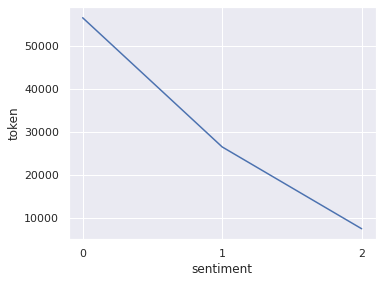

In [10]:
import seaborn as sns

print('------------------------------------------------')
print('Palabras totales por cada sentimiento')
print('------------------------------------------------')
print(tweets_tidy.groupby(by='sentiment')['token'].count())

sns.set(rc={'figure.figsize':(5.5,4.27)})
sns.lineplot(data=tweets_tidy.groupby(by='sentiment')['token'].count())


------------------------------------------------
Palabras distintas por cada sentimiento
------------------------------------------------
sentiment
0    5645
1    3706
2    2236
Name: token, dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='token'>

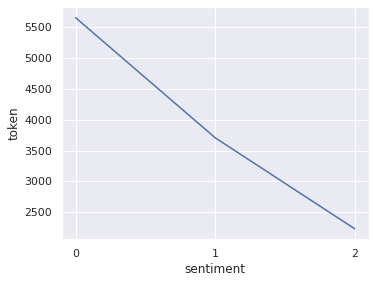

In [11]:
print('------------------------------------------------')
print('Palabras distintas por cada sentimiento')
print('------------------------------------------------')
print(tweets_tidy.groupby(by='sentiment')['token'].nunique())
sns.lineplot(data=tweets_tidy.groupby(by='sentiment')['token'].nunique())


------------------------------------------------
Longitud media y desviacion de los tweets de cada sentimiento
------------------------------------------------
                mean       std
sentiment                     
0          10.379121  3.179644
1           8.925814  3.794530
2           7.320700  3.369895


<AxesSubplot:xlabel='sentiment'>

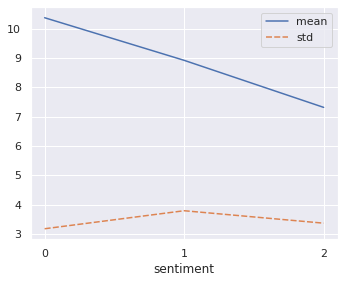

In [12]:
print('------------------------------------------------')
print('Longitud media y desviacion de los tweets de cada sentimiento')
print('------------------------------------------------')
temp_df = pd.DataFrame(tweets_tidy.groupby(by=['sentiment', 'id'])['token'].count())
print(temp_df.reset_index().groupby('sentiment')['token'].agg(['mean','std']))
sns.lineplot(data=temp_df.reset_index().groupby('sentiment')['token'].agg(['mean', 'std']))


In [13]:
print('------------------------------------------------')
print(' Palabras mas utilizadas de cada sentimiento')
print('------------------------------------------------')
tweets_tidy.groupby(['sentiment', 'token'])['token'].count().reset_index(name='count').groupby('sentiment') \
           .apply(lambda x: x.sort_values('count', ascending=False).head(5))

------------------------------------------------
 Palabras mas utilizadas de cada sentimiento
------------------------------------------------


sentiment        token  count
sentiment                                    
0         5340          0          url   3784
          4047          0        pizza   3063
          3461          0      mostaza   2993
          955           0     cilantro   2932
          3931          0    pepinillo   2927
1         7266          1  hamburguesa   1895
          9152          1          url   1617
          8322          1        pizza   1157
          7907          1      mostaza   1095
          8951          1        sushi   1091
2         10313         2  hamburguesa    976
          11456         2         user    395
          11454         2          url    260
          9792          2        comer    135
          10231         2        ganas    120

En este punto se hace notorio que hay ciertas palabras que se repiten reiteradas veces. Como pepinillo, cilantro o mostaza, haciendo un poco de investigación se descubre que hay un comentario que se repite mucho, a continuación se muestran ejemplos:

In [14]:
print(tweets.iloc[1817,1])
print('##################################\n')
print('##################################')
print(tweets.iloc[5237,1])
print('##################################\n')
print('##################################')
print(tweets.iloc[9012,1])

Usa 🤢 para marcar lo que no comes

mostaza: 
pepinillo: 🤢
cilantro: 
pizza con piña:
sushi: 🤢🤢🤢
brócoli: 
champiñon… https://t.co/OakY3XCRf8
##################################

##################################
Usa 🥰o🤢 para lo que te gusta o no.

mostaza: 🥰
pepinillo: 🤢
cilantro: 🤢
pizza con piña: 🥰
sushi:🥰
brócoli: 🥰
champi… https://t.co/HTZ55BnTtI
##################################

##################################
usa 👎 para marcar lo que no comes

mostaza: 
pepinillo: 👎
cilantro: 👎
pizza con piña: 👎
sushi: 👎
brócoli: 
champiño… https://t.co/u7raIVffzt


Dado que este comentario, de cierta forma esta agregando ruido a la tarea, se decide retirarlo del conjunto de datos, pero no se descarta, dado que es posible retirar información útil, como por ejemplo que tanto le disgustan ciertos ingredientes a ciertas personas. 

Se retiran las filas (alrededor de 3500) cuya lista de tokens contiene los tokens mostaza, pepinillo, cilantro, los cuales son generales para todos los comentarios de este tipo y se vuelve a analizar lo anterior.

In [15]:
tweets_cadena = tweets[tweets['tokenized_text'].apply(lambda x: 'mostaza' in x and 'pepinillo' in x and 'cilantro' in x)]
tweets_clean = tweets.drop(tweets_cadena.index,axis=0)

tweets_clean_tidy = tweets_clean.explode(column='tokenized_text')
tweets_clean_tidy = tweets_clean_tidy.drop(columns='texts')
tweets_clean_tidy = tweets_clean_tidy.rename(columns={'Unnamed: 0': 'id', 'tokenized_text':'token'})

print('------------------------------------------------')
print('Palabras totales por cada sentimiento')
print('------------------------------------------------')
print(tweets_clean_tidy.groupby(by='sentiment')['token'].count())

print('\n------------------------------------------------')
print('Palabras distintas por cada sentimiento')
print('------------------------------------------------')
print(tweets_clean_tidy.groupby(by='sentiment')['token'].nunique())

print('\n------------------------------------------------')
print('Longitud media y desviacion de los tweets de cada sentimiento')
print('------------------------------------------------')
temp_df = pd.DataFrame(tweets_clean_tidy.groupby(by=['sentiment', 'id'])['token'].count())
print(temp_df.reset_index().groupby('sentiment')['token'].agg(['mean','std']))

print('\n------------------------------------------------')
print(' Palabras mas utilizadas de cada sentimiento')
print('------------------------------------------------')
tweets_clean_tidy.groupby(['sentiment', 'token'])['token'].count().reset_index(name='count').groupby('sentiment') \
           .apply(lambda x: x.sort_values('count', ascending=False).head(5))

------------------------------------------------
Palabras totales por cada sentimiento
------------------------------------------------
sentiment
0    21832
1    14650
2     7495
Name: token, dtype: int64

------------------------------------------------
Palabras distintas por cada sentimiento
------------------------------------------------
sentiment
0    5436
1    3666
2    2233
Name: token, dtype: int64

------------------------------------------------
Longitud media y desviacion de los tweets de cada sentimiento
------------------------------------------------
               mean       std
sentiment                    
0          8.367957  3.594408
1          7.347041  3.721208
2          7.305068  3.361985

------------------------------------------------
 Palabras mas utilizadas de cada sentimiento
------------------------------------------------


sentiment        token  count
sentiment                                    
0         2346          0  hamburguesa   2214
          5159          0         user   1021
          5153          0          url    933
          4675          0           si    236
          3908          0        pizza    214
1         7043          1  hamburguesa   1786
          8911          1         user    709
          8907          1          url    632
          8301          1       quiero    252
          6902          1        ganas    188
2         10061         2  hamburguesa    976
          11204         2         user    393
          11202         2          url    257
          9543          2        comer    135
          9981          2        ganas    120

Es posible notar un descenso en la cantidad de palabras usadas en general lo cual es esperado, ya que se reduce el tamaño del set de datos casi un tercio.
Las palabras distintas no varian demasiado, el vocabulario empleado en twiter es acotado, el conjunto de tweets que tiene la cadena no agrega palabras nuevas. 
Y para la longitud media de los tweets, de cierta manera, el rate se mantiene igual. Los tweets más positivos continúan siendo los más cortos. 

----

Es posible notar como los tres tokens más empleados en todos los sentimientos son **hamburguesa**, **user** y **url**. Esto se debe al buscar tweets que contengan la palabra **hamburguesa**, todos ellos la contendrán. Aparte, al ser un sitio social, es normal que los usuarios mencionen a sus vínculos e incluyan links a fotos, o sitios que les resulten relevantes.

### Correlación entre los tweets para cada sentimiento
Queremos cuantificar la similitud entre los sentimientos positivo-neutral-negativo de los tweets. Una forma es confirmando qué sentimientos utilizan palabras similares entre sí. Se trabaja con la medida 1 - distancia coseno.

La hipótesis sería que la correlación entre los tweets positivos y neutrales debería ser mayor a la que hay entre los tweets positivos y los negativos por ejemplo. 

In [16]:
tweets_pivot = tweets_clean_tidy.groupby(["sentiment","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="sentiment", values= "count")
tweets_pivot.columns.name = None

from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,0,1,2
0,1.000000,0.989176,0.973101
1,0.989176,1.000000,0.986444
2,0.973101,0.986444,1.000000


Se confirma la hipótesis de que la correlación entre el texto positivo y el neutral es mayor que entre el texto positivo y negativo.
Aparte, se ve que la correlación entre el texto neutral y el positivo es mayor que entre el texto neutral y el negativo. 
Aunque es muy poca la diferencia en las correlaciones, se podría concluir que el lenguaje empleado a la hora de realizar una queja, expresar un disgusto o decir algo mientras se está enojado, varía comparando con el lenguaje empleado usualmente. 

### Comparación en el uso de palabras
A continuación se estudia palabras que se utilizan mucho en un sentimiento pero no en otro, por pares. 

Para realizar este cálculo se cuantifica la frencuencia de cada una de las palabras por sentimiento, si una palabra se utiliza en un tweet positivo pero no en uno negativo, debe aparecer esa palabra en su registro con frecuencia igual a cero.


------------------------------------------------
Palabras más características para sentimiento positivo vs negativo
------------------------------------------------


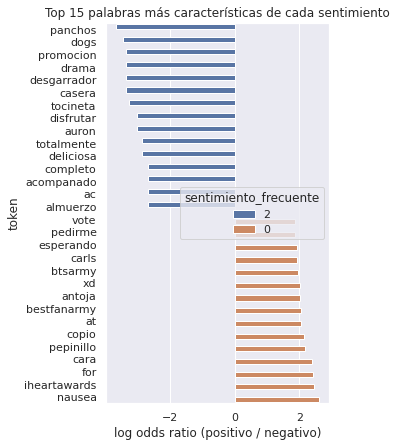

In [17]:
import matplotlib.pyplot as plt

print('\n------------------------------------------------')
print('Palabras más características para sentimiento positivo vs negativo')
print('------------------------------------------------')
# Pivotaje y despivotaje
tweets_pivot = tweets_clean_tidy.groupby(["sentiment","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="sentiment", values= "count")

tweets_pivot = tweets_pivot.fillna(value=0)
tweets_pivot.columns.name = None

tweets_unpivot = tweets_pivot.melt(value_name='n', var_name='sentiment', ignore_index=False)
tweets_unpivot = tweets_unpivot.reset_index()

# Selección de los sentimientos positivo y negativo
tweets_unpivot = tweets_unpivot[tweets_unpivot.sentiment.isin(['0', '2'])]

# Se añade el total de palabras de cada sentimiento
tweets_unpivot = tweets_unpivot.merge(
                    tweets_clean_tidy.groupby('sentiment')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'sentiment'
                 )

# Cálculo de odds y log of odds de cada palabra
tweets_logOdds = tweets_unpivot.copy()
tweets_logOdds['odds'] = (tweets_logOdds.n + 1) / (tweets_logOdds.N + 1)
tweets_logOdds = tweets_logOdds[['token', 'sentiment', 'odds']] \
                    .pivot(index='token', columns='sentiment', values='odds')
tweets_logOdds.columns.name = None
tweets_logOdds['log_odds']     = np.log(tweets_logOdds.iloc[:,0].values/tweets_logOdds.iloc[:,1].values)
tweets_logOdds['abs_log_odds'] = np.abs(tweets_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser negativa. Esto es así porque el ratio sea ha
# calculado como negativo/positivo.
tweets_logOdds['sentimiento_frecuente'] = np.where(tweets_logOdds.log_odds > 0, "0", "2")

top_30 = tweets_logOdds[['log_odds', 'abs_log_odds', 'sentimiento_frecuente']] \
        .groupby('sentimiento_frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'sentimiento_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 15 palabras más características de cada sentimiento')
ax.set_xlabel('log odds ratio (positivo / negativo)');

En esta gráfica se visualizan las palabras más características para cada sentimiento, o sea aquellas que estan más o únicamente presentes en un sentimiento. Los resultados que arroja resultan interesantes, ya que cuando el sentimiento es positivo, se encuentran palabras como:
- promoción
- casera
- tocineta
- deliciosa
- acompañado

Esto da a entender por ejemplo, que ofrecer una promoción, o que la comida esté acompañada de una guarnición resulta positivo para los compradores. La comida casera también, se sabe, que es de gusto para quienes la consumen. También la panceta aparece como ingrediente regular entre los tweets positivos.
Sin embargo, palabras como:
- esperando
- carls
- pepinillo
- cara
- nausea

son las que más caracterizan los tweets con sentimiento negativo. Lo que tiene sentido, ya que a nadie le gusta tener que esperar demasiado para recibir su comida, o que la misma sea cara. También es posible concluir que a las personas en general parece no agradarles que haya pepinillos en su hamburguesa. 
Por último, Carls es un negocio de comida rápida en España, parece que ronda un sentimiento negativo en cuanto a sus hamburguesas.

### Tf-Idf

In [18]:
# Cálculo term-frecuency (tf)
tf = tweets_tidy.copy()
tf = tf.groupby(["id", "token"])["token"].agg(["count"]).reset_index()
tf['total_count'] = tf.groupby('id')['count'].transform(sum)
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(3)

,id,token,count,total_count,tf
47895,5543,hamburguesa,1,20,0.05
47893,5543,digo,1,20,0.05
47894,5543,fantastico,1,20,0.05


In [19]:
# Inverse document frequency
idf = tweets_tidy.copy()
total_documents = idf["id"].drop_duplicates().count()
idf = idf.groupby(["token", "id"])["token"].agg(["count"]).reset_index()
idf['n_documentos'] = idf.groupby('token')['count'].transform(sum)

idf['idf'] = np.log(total_documents / idf['n_documentos'])
idf = idf[["token","n_documentos", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_documentos,idf
76089,url,5661,0.514317
29531,hamburguesa,5104,0.617893
59882,pizza,4339,0.780274


In [20]:
# Term Frequency - Inverse Document Frequency

tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="id").head()

,id,token,count,total_count,tf,n_documentos,idf,tf_idf
0,0,buscaba,1,11,0.090909,1,9.155673,0.832334
45,0,mismo,1,11,0.090909,32,5.689937,0.517267
37,0,mano,1,11,0.090909,9,6.958448,0.632586
78,0,url,1,11,0.090909,5661,0.514317,0.046756
18,0,llena,1,11,0.090909,19,6.211234,0.564658


No se logran conclusiones claras al aplicar Tf-Idf.

### Tweets cadena
Como se muestra anteriormente, un gran porcentaje de los tweets utilizados son una especie de *cadena*, se intentará sacar una idea de lo que a la gente le desagrada en general.
Al obtener los tweets, los mismos quedaron cortados, asi únicamente son visibles algunos de los ingredientes de la cadena:
- Mostaza
- Pepinillo
- Cilantro
- Pizza con piña
- Sushi
- Brócoli
- Champiñones
- Hígado
- Hamburguesa
- Hot dogs
- Aceitunas

A efectos de nuestro negocio, nos interesa en particular *mostaza, pepinillo, cilantro, champiñones, hamburguesa y aceitunas*. Se propone realizar un conteo con rate de la cantidad de veces que las personas ponen "🤢" en uno de estos ingredientes.

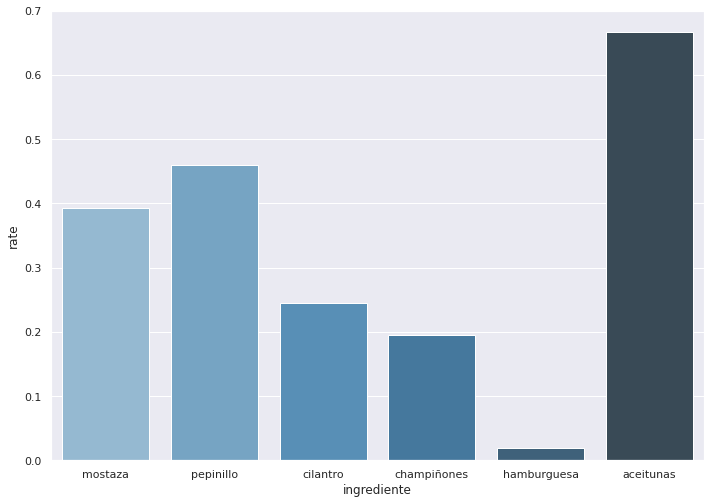

In [21]:
rates = pd.DataFrame(columns = ['ingrediente', 'rate'])

# Mostaza
mostaza_bad = re.compile(r'[mM]ostaza\: *🤢')
mostaza = re.compile(r'[mM]ostaza:')
rate_mostaza = tweets_cadena.texts.str.contains(mostaza_bad).sum()/tweets_cadena.texts.str.contains(mostaza).sum()
rates = rates.append({'ingrediente': 'mostaza', 'rate': rate_mostaza}, ignore_index=True)

# Pepinillo
pepinillo_bad = re.compile(r'[pP]epinillo\: *🤢')
pepinillo = re.compile(r'[pP]epinillo:')
rate_pepinillo = tweets_cadena.texts.str.contains(pepinillo_bad).sum()/tweets_cadena.texts.str.contains(pepinillo).sum()
rates = rates.append({'ingrediente': 'pepinillo', 'rate': rate_pepinillo}, ignore_index=True)

# Cilantro
cilantro_bad = re.compile(r'[cC]ilantro\: *🤢')
cilantro = re.compile(r'[cC]ilantro:')
rate_cilantro = tweets_cadena.texts.str.contains(cilantro_bad).sum()/tweets_cadena.texts.str.contains(cilantro).sum()
rates = rates.append({'ingrediente': 'cilantro', 'rate': rate_cilantro}, ignore_index=True)

# Champiñones
champiñones_bad = re.compile(r'[cC]hampiñones\: *🤢')
champiñones = re.compile(r'[cC]hampiñones:')
rate_champiñones = tweets_cadena.texts.str.contains(champiñones_bad).sum()/tweets_cadena.texts.str.contains(champiñones).sum()
rates = rates.append({'ingrediente': 'champiñones', 'rate': rate_champiñones}, ignore_index=True)

# Hamburguesa
hamburguesa_bad = re.compile(r'[hH]amburguesa\: *🤢')
hamburguesa = re.compile(r'[hH]amburguesa:')
rate_hamburguesa = tweets_cadena.texts.str.contains(hamburguesa_bad).sum()/tweets_cadena.texts.str.contains(hamburguesa).sum()
rates = rates.append({'ingrediente': 'hamburguesa', 'rate': rate_hamburguesa}, ignore_index=True)

# Aceitunas
aceitunas_bad = re.compile(r'[aA]ceitunas\: *🤢')
aceitunas = re.compile(r'[aA]ceitunas:')
rate_aceitunas = tweets_cadena.texts.str.contains(aceitunas_bad).sum()/tweets_cadena.texts.str.contains(aceitunas).sum()
rates = rates.append({'ingrediente': 'aceitunas', 'rate': rate_aceitunas}, ignore_index=True)

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="ingrediente", y="rate", data=rates, palette="Blues_d")


Viendo la gráfica anterior, es posible concluir que un negocio de hamburguesas es una buena idea, dado que a un porcentaje mínimo de personas parece disgustarles la comida.
Sin embargo, a la hora de elegir los ingredientes que deberían formar parte del menu, es claramente visible que un gran porcentaje de personas, detestan las aceitunas, probablemente no deberían ofrecerse.
A esto le sigue la mostaza y los pepinillos, de los cuales, a la mitad de los comensales parece gustarle y a la otra mitad no. Se puede considerar hacerlos opcionales a la hora de ofrecer una hamburguesa con los mismos. 

## Conclusiones

Muchas personas realizan tweets diariamente, recopilando información, es posible extraer una idea de lo que se opina en la sociedad.La API de tweeter ofrecer la posibilidad de buscar tweets en base a palabras. Dado que nuestro fin era obtener información para un negocio de hamburguesas, se busca todo aquello que contenga la palabra hamburguesa.

Se emplea un clasificador para etiquetar los tweets en 3 sentimientos. A partir de estas etiquetas se visualiza que predomina el sentimiento negativo entre los tweets. Por lo que se puede concluir que la mayoria de la gente realiza tweets para expresar algo malo.

Luego se estudian los tweets en si, en particular su largo promedio y cantidad de palabras. Se visualiza que el largo promedio del tweet de sentimiento negativo es mayor al resto.
Se encuentran palabras como esperando, nausea o pepinillos entre las palabras que mas caracterizan este sentimiento.
Y palabras como casero, deliciosa, completo entre las palabras que caracterizan en el sentimiento positivo.

Finalmente, en cuanto a los ingredientes, se concluye que las aceitunas no son un ingrediente que a demasiada gente le agrade por lo que no deberia incluirse en el menu. Otros ingredientes como la mostaza o los pepinillos, se pueden ofrecer de forma opcional, ya que a la mitad de la gente le gustan, y a la otra mitad no. 